In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('pd_speech_features.csv')
df.drop('id', axis=1, inplace=True)

In [3]:
scaler = MinMaxScaler()
df[df.columns[:]] = scaler.fit_transform(df[df.columns[:]])

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print('Number of data in each class :')
print('before split : ',Counter(y))

Number of data in each class :
before split :  Counter({1.0: 564, 0.0: 192})


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('before balancing : ',Counter(y_train))


from imblearn.over_sampling import SMOTE

SMOTE = SMOTE(sampling_strategy='minority')
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)
print('after balancing (over_sampling) : ',Counter(y_train_SMOTE))

before balancing :  Counter({1.0: 398, 0.0: 131})
after balancing (over_sampling) :  Counter({1.0: 398, 0.0: 398})


# ICA

In [6]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=50)
X_train_transformed = ica.fit_transform(X_train_SMOTE)  # Reconstruct signals
X_test_transformed = ica.transform(X_test, copy=True)
X_train_transformed.shape

(796, 50)

In [7]:
train_data = np.array(X_train_transformed)
train_labels = np.array(y_train_SMOTE)
test_data = np.array(X_test_transformed)
test_labels = np.array(y_test)

test_data.shape , train_data.shape

((227, 50), (796, 50))

## Evaluation Metrics

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluation(test_labels, predicted):
    confusion_mtx = confusion_matrix(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)
    f1score = f1_score(test_labels, predicted)
    report = classification_report(test_labels, predicted)

    FP = confusion_mtx.sum(axis=0) - np.diag(confusion_mtx)  
    FN = confusion_mtx.sum(axis=1) - np.diag(confusion_mtx)
    TP = np.diag(confusion_mtx)
    TN = confusion_mtx.sum() - (FP + FN + TP)
    
    recall = TP/(TP+FN)  # Sensitivity, hit rate, recall, or true positive rate   
    precision = TP/(TP+FP)  # Precision or positive predictive value
    
    print("Accuracy = {0:0.2f}".format(accuracy))
    print("Sensitivity = {0:0.2f}".format(recall[1]))
    print("Precision = {0:0.2f}".format(precision[1]))
    print("F1_score = {0:0.2f}".format(f1score))
    print('\n')
    print("Confusion matrix:\n%s" % confusion_mtx)

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def plot_ROC(y_test, y_pred):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(5,3.5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=13)
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.title('Receiver Operating Characteristic',fontsize=14)
    plt.legend(loc="lower right",fontsize=12)
    plt.savefig('Log_ROC')
    plt.show()

## Logistic regression

Accuracy = 0.81
Sensitivity = 0.86
Precision = 0.88
F1_score = 0.87


Confusion matrix:
[[ 41  20]
 [ 24 142]]


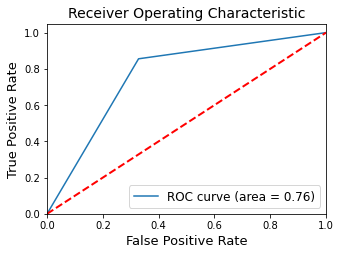

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## SVM

In [11]:
from sklearn import svm
#'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

### defferent kernel 

Accuracy = 0.86
Sensitivity = 0.95
Precision = 0.88
F1_score = 0.91


Confusion matrix:
[[ 39  22]
 [  9 157]]


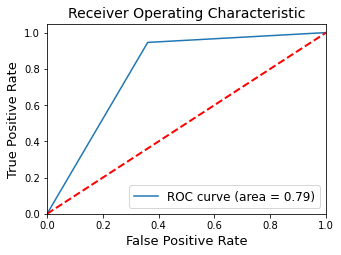

In [12]:
clf = svm.SVC(kernel='rbf')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.89
Sensitivity = 0.95
Precision = 0.91
F1_score = 0.93


Confusion matrix:
[[ 45  16]
 [  8 158]]


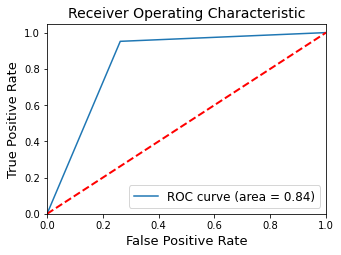

In [13]:
clf = svm.SVC(kernel='poly')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.78
Sensitivity = 0.80
Precision = 0.90
F1_score = 0.84


Confusion matrix:
[[ 46  15]
 [ 34 132]]


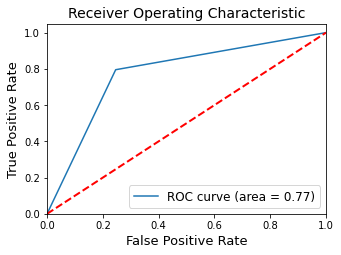

In [14]:
clf = svm.SVC(kernel='linear')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

##  Decision Tree

Accuracy = 0.76
Sensitivity = 0.86
Precision = 0.83
F1_score = 0.84


Confusion matrix:
[[ 31  30]
 [ 24 142]]


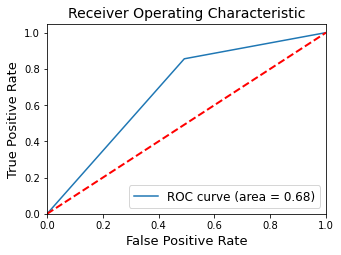

In [15]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## k-NN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

different_k = np.array([1,2,3,4,5,6,7,8,9,10])

CCR_knn = []
for i in different_k:
    knn = KNeighborsClassifier(n_neighbors=i).fit(train_data, train_labels)
    predicted = knn.predict(test_data)
    CCR_knn.append(accuracy_score(test_labels, predicted))
    #print(i)
    #print(CCR_knn)

k_opt = different_k[CCR_knn.index(max(CCR_knn))]
print('k_opt =',k_opt)

k_opt = 1


Accuracy = 0.87
Sensitivity = 0.87
Precision = 0.95
F1_score = 0.91


Confusion matrix:
[[ 53   8]
 [ 21 145]]


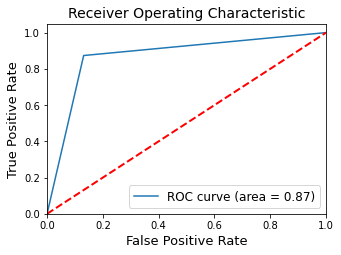

In [17]:
k = k_opt
knn = KNeighborsClassifier(n_neighbors=k_opt).fit(train_data, train_labels)
predicted = knn.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## GMM

In [18]:
from sklearn.mixture import GaussianMixture
# 'full', 'tied', 'diag', 'spherical'

### different covariance type

Accuracy = 0.41
Sensitivity = 0.32
Precision = 0.71
F1_score = 0.44


Confusion matrix:
[[ 39  22]
 [113  53]]


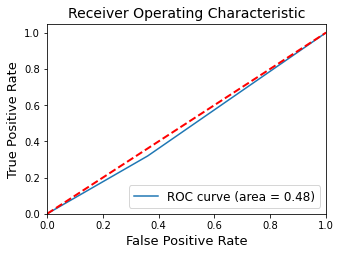

In [19]:
GMM = GaussianMixture(n_components=2, covariance_type='full').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.75
Sensitivity = 0.99
Precision = 0.75
F1_score = 0.85


Confusion matrix:
[[  7  54]
 [  2 164]]


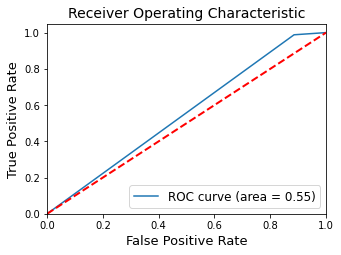

In [20]:
GMM = GaussianMixture(n_components=2, covariance_type='tied').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.41
Sensitivity = 0.23
Precision = 0.83
F1_score = 0.37


Confusion matrix:
[[ 53   8]
 [127  39]]


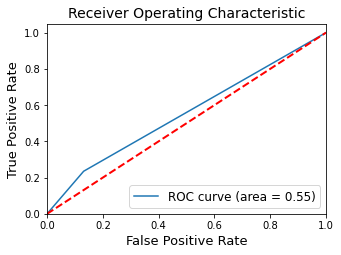

In [21]:
GMM = GaussianMixture(n_components=2, covariance_type='spherical').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)